## Fine-tuning Stable Diffusion XL with DreamBooth and LoRA on a free-tier Colab Notebook 🧨

In this notebook, we show how to fine-tune [Stable Diffusion XL (SDXL)](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/stable_diffusion_xl) with [DreamBooth](https://huggingface.co/docs/diffusers/main/en/training/dreambooth) and [LoRA](https://huggingface.co/docs/diffusers/main/en/training/lora) on a T4 GPU.

SDXL consists of a much larger UNet and two text encoders that make the cross-attention context quite larger than the previous variants.

So, to pull this off, we will make use of several tricks such as gradient checkpointing, mixed-precision, and 8-bit Adam. So, hang tight and let's get started 🧪

In [18]:
pip install --upgrade ipywidgets nbformat nbconvert


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.9 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


## Setup 🪓

In [1]:
# Check the GPU
!nvidia-smi

Mon Apr  7 09:28:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Install dependencies.
!pip install bitsandbytes transformers accelerate peft -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.0 MB/s eta 0:00:00


Make sure to install `diffusers` from `main`.

In [3]:
!pip install git+https://github.com/huggingface/diffusers.git -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Download diffusers SDXL DreamBooth training script.

In [4]:
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py

--2025-04-07 09:31:46--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84961 (83K) [text/plain]
Saving to: ‘train_dreambooth_lora_sdxl.py’

train_dreambooth_lo 100%[===================>]  82.97K  --.-KB/s    in 0.02s   

2025-04-07 09:31:46 (4.80 MB/s) - ‘train_dreambooth_lora_sdxl.py’ saved [84961/84961]



## Dataset 🐶

**Let's get our training data!**
For this example, we'll download some images from the hub

If you already have a dataset on the hub you wish to use, you can skip this part and go straight to: "Prep for
training 💻" section, where you'll simply specify the dataset name.

If your images are saved locally, and/or you want to add BLIP generated captions,
upload the file through the cell below, or upload them manually to specified directory.



In [6]:
import os

local_dir = "./medieval chinese/" #@param
os.makedirs(local_dir,exist_ok=True)

**Upload** example images from your local files. You can also upload your images manually to the speficied folder.

In [7]:
from google.colab import files

# pick a name for the image folder
os.chdir(local_dir)

# choose and upload local images into the newly created directory
uploaded_images = files.upload()
os.chdir("/content") # back to parent directory

Saving 1353763927-0445910-www.nevsepic.com.ua.jpg to 1353763927-0445910-www.nevsepic.com.ua.jpg
Saving 1353763928-0448186-www.nevsepic.com.ua.jpg to 1353763928-0448186-www.nevsepic.com.ua.jpg
Saving 1353763928-0448215-www.nevsepic.com.ua.jpg to 1353763928-0448215-www.nevsepic.com.ua.jpg
Saving 1353763929-0448181-www.nevsepic.com.ua.jpg to 1353763929-0448181-www.nevsepic.com.ua.jpg
Saving 1353763930-0448230-www.nevsepic.com.ua.jpg to 1353763930-0448230-www.nevsepic.com.ua.jpg
Saving 1353763931-0445971-www.nevsepic.com.ua.jpg to 1353763931-0445971-www.nevsepic.com.ua.jpg
Saving 1353763932-0445863-www.nevsepic.com.ua.jpg to 1353763932-0445863-www.nevsepic.com.ua.jpg
Saving 1353763932-0445870-www.nevsepic.com.ua.jpg to 1353763932-0445870-www.nevsepic.com.ua.jpg
Saving 1353763933-0448237-www.nevsepic.com.ua.jpg to 1353763933-0448237-www.nevsepic.com.ua.jpg
Saving 1353763934-0445862-www.nevsepic.com.ua.jpg to 1353763934-0445862-www.nevsepic.com.ua.jpg
Saving 1353763935-0445860-www.nevsepic.c

Preview the images:

In [8]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

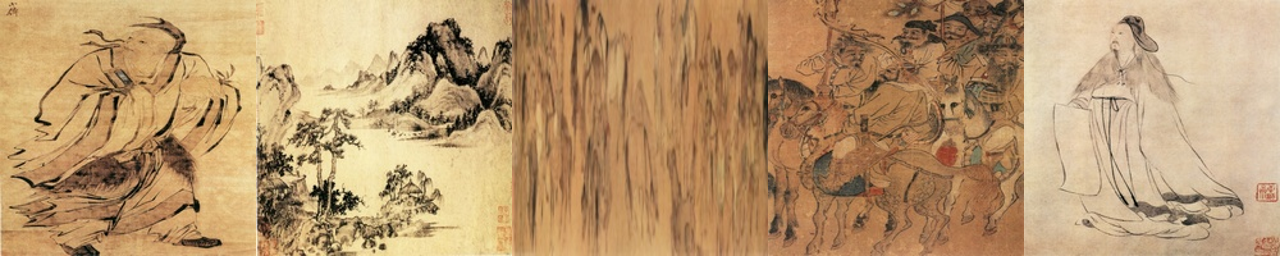

In [9]:
import glob

# change path to display images from your local dir
img_paths = "./medieval chinese/*.jpg"
imgs = [Image.open(path) for path in glob.glob(img_paths)]

num_imgs_to_preview = 5
image_grid(imgs[:num_imgs_to_preview], 1, num_imgs_to_preview)

### Generate custom captions with BLIP
Load BLIP to auto caption your images:

In [10]:
import requests
from transformers import AutoProcessor, BlipForConditionalGeneration
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# load the processor and the captioning model
blip_processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base",torch_dtype=torch.float16).to(device)

# captioning utility
def caption_images(input_image):
    inputs = blip_processor(images=input_image, return_tensors="pt").to(device, torch.float16)
    pixel_values = inputs.pixel_values

    generated_ids = blip_model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_caption

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [11]:
import glob
from PIL import Image

# create a list of (Pil.Image, path) pairs
local_dir = "./medieval chinese/"
imgs_and_paths = [(path,Image.open(path)) for path in glob.glob(f"{local_dir}*.jpg")]

In [12]:
import json

caption_prefix = "artwork in medieval Chinese painting style, " #@param
with open(f'{local_dir}metadata.jsonl', 'w') as outfile:
  for img in imgs_and_paths:
      caption = caption_prefix + caption_images(img[1]).split("\n")[0]
      entry = {"file_name":img[0].split("/")[-1], "prompt": caption}
      json.dump(entry, outfile)
      outfile.write('\n')

In [13]:
!cat "medieval chinese"/metadata.jsonl

{"file_name": "1353764015-0448238-www.nevsepic.com.ua.jpg", "prompt": "artwork in medieval Chinese painting style, the cover of the book, the art of the japanese"}
{"file_name": "1353763991-0445854-www.nevsepic.com.ua.jpg", "prompt": "artwork in medieval Chinese painting style, a painting of a mountain landscape"}
{"file_name": "1353763949-0448243-www.nevsepic.com.ua.jpg", "prompt": "artwork in medieval Chinese painting style, a painting of a brown and black tree"}
{"file_name": "1353763978-0448245-www.nevsepic.com.ua.jpg", "prompt": "artwork in medieval Chinese painting style, a painting of a group of men riding horses"}
{"file_name": "1353764038-0448169-www.nevsepic.com.ua.jpg", "prompt": "artwork in medieval Chinese painting style, a woman in a long dress with a fan"}
{"file_name": "1353764005-0445972-www.nevsepic.com.ua.jpg", "prompt": "artwork in medieval Chinese painting style, a painting of a landscape with trees and mountains"}
{"file_name": "1353764009-0448239-www.nevsepic.com

Free some memory:

In [14]:
import gc

# delete the BLIP pipelines and free up some memory
del blip_processor, blip_model
gc.collect()
torch.cuda.empty_cache()

## Prep for training 💻

Initialize `accelerate`:

In [15]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!accelerate config default

accelerate configuration saved at /root/.cache/huggingface/accelerate/default_config.yaml


In [16]:
from huggingface_hub import notebook_login
notebook_login()

### Launch training 🚀🚀🚀

In [17]:
!pip install datasets -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.


In [18]:
#!/usr/bin/env bash
!accelerate launch train_dreambooth_lora_sdxl.py \
  --pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0" \
  --pretrained_vae_model_name_or_path="madebyollin/sdxl-vae-fp16-fix" \
  --dataset_name="medieval chinese" \
  --output_dir="medieval_chinese_style_LoRA" \
  --caption_column="prompt"\
  --mixed_precision="fp16" \
  --instance_prompt="artwork in medieval Chinese painting style" \
  --resolution=512 \
  --train_batch_size=2 \
  --gradient_accumulation_steps=3 \
  --gradient_checkpointing \
  --learning_rate=1e-4 \
  --snr_gamma=5.0 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --max_train_steps=500 \
  --checkpointing_steps=250 \
  --seed="0"

2025-04-07 09:39:36.226938: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744018776.261333    3260 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744018776.270323    3260 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
04/07/2025 09:39:41 - INFO - __main__ - Distributed environment: DistributedType.NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

tokenizer_config.json: 100% 737/737 [00:00<00:00, 6.00MB/s]
vocab.json: 100% 1.06M/1.06M [00:00<00:00, 24.4MB/s]
merges.txt: 100% 525k/525k [00:00<00:00, 19.1MB/s]
special_tokens_map.json: 100% 472/472 [00:00<00:00, 3.01MB/s]
tokenizer_config.json: 100% 

In [19]:
!ls medieval_chinese_style_LoRA

checkpoint-250	checkpoint-500	logs  pytorch_lora_weights.safetensors


### Save your model to the hub and check it out 🔥

In [20]:
from huggingface_hub import whoami
from pathlib import Path
#@markdown make sure the `output_dir` you specify here is the same as the one used for training
output_dir = "medieval_chinese_style_LoRA" #@param
username = whoami(token=Path("/root/.cache/huggingface/"))["name"]
repo_id = f"{username}/{output_dir}"

In [21]:
# @markdown Sometimes training finishes succesfuly (i.e. a **.safetensores** file with the LoRA weights saved properly to your local `output_dir`) but there's not enough RAM in the free tier to push the model to the hub 🙁
# @markdown
# @markdown To mitigate this, run this cell with your training arguments to make sure your model is uploaded! 🤗

# push to the hub🔥
from train_dreambooth_lora_sdxl import save_model_card
from huggingface_hub import upload_folder, create_repo

repo_id = create_repo(repo_id, exist_ok=True).repo_id

# change the params below according to your training arguments
save_model_card(
    repo_id = repo_id,
    images=[],
    base_model="stabilityai/stable-diffusion-xl-base-1.0",
    train_text_encoder=False,
    instance_prompt="artwork in medieval Chinese painting style",
    validation_prompt=None,
    repo_folder=output_dir,
    use_dora = False,
    vae_path="madebyollin/sdxl-vae-fp16-fix",
)

upload_folder(
    repo_id=repo_id,
    folder_path=output_dir,
    commit_message="End of training",
    ignore_patterns=["step_*", "epoch_*"],
)

optimizer.bin:   0%|          | 0.00/15.1M [00:00<?, ?B/s]

pytorch_lora_weights.safetensors:   0%|          | 0.00/23.4M [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

Upload 13 LFS files:   0%|          | 0/13 [00:00<?, ?it/s]

scheduler.bin:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/988 [00:00<?, ?B/s]

optimizer.bin:   0%|          | 0.00/15.1M [00:00<?, ?B/s]

pytorch_lora_weights.safetensors:   0%|          | 0.00/23.4M [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/988 [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

events.out.tfevents.1744018945.28527436b477.3260.1:   0%|          | 0.00/3.35k [00:00<?, ?B/s]

events.out.tfevents.1744018945.28527436b477.3260.0:   0%|          | 0.00/125k [00:00<?, ?B/s]

pytorch_lora_weights.safetensors:   0%|          | 0.00/23.4M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ED1LOAD/medieval_chinese_style_LoRA/commit/aa62285b20fdb38bfcdf0555a250015059d9051b', commit_message='End of training', commit_description='', oid='aa62285b20fdb38bfcdf0555a250015059d9051b', pr_url=None, repo_url=RepoUrl('https://huggingface.co/ED1LOAD/medieval_chinese_style_LoRA', endpoint='https://huggingface.co', repo_type='model', repo_id='ED1LOAD/medieval_chinese_style_LoRA'), pr_revision=None, pr_num=None)

In [22]:
from IPython.display import display, Markdown

link_to_model = f"https://huggingface.co/{repo_id}"
display(Markdown("### Your model has finished training.\nAccess it here: {}".format(link_to_model)))

### Your model has finished training.
Access it here: https://huggingface.co/ED1LOAD/medieval_chinese_style_LoRA

## Inference 🐕

In [1]:
import torch
from diffusers import DiffusionPipeline, AutoencoderKL

repo_id = "ED1LOAD/medieval_chinese_style_LoRA"

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True
)
pipe.load_lora_weights(repo_id)
_ = pipe.to("cuda")

config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

pytorch_lora_weights.safetensors:   0%|          | 0.00/23.4M [00:00<?, ?B/s]

In [2]:
prompt = "artwork of traditional Chinese landscape (shanshui), featuring towering mountains, steep cliffs, winding rivers, cascading waterfalls, and drifting mist, painted in the medieval Chinese ink wash style, soft brushstrokes and serene atmosphere, ancient pine trees on rocky slopes"
negative_prompt = "low quality, blurry, western comic style, photorealistic, distorted shapes, neon colors"

image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
).images[0]

image.show()

image.save("chinese_shanshui_landscape.png")


  0%|          | 0/30 [00:00<?, ?it/s]

In [3]:
prompt = "artwork of traditional Chinese landscape (shanshui), with misty mountains, dense forest of pine and bamboo trees, small wooden huts hidden among the trees, river gently flowing through the valley, soft morning fog, painted in ancient Chinese ink wash style, peaceful and poetic atmosphere"
negative_prompt = "low quality, blurry, cartoon style, western fantasy, neon colors, photorealistic, distorted details"

image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
).images[0]

image.show()

image.save("chinese_forest_huts_landscape.png")


  0%|          | 0/30 [00:00<?, ?it/s]

In [4]:
prompt = "artwork of traditional Chinese landscape (shanshui) featuring reclusive sages living in harmony with nature, small huts nestled in pine forests, wise old men in flowing robes sitting by a river or reading scrolls under ancient trees, misty mountains and gentle waterfalls in the background, painted in classical Chinese ink wash style, serene and contemplative atmosphere"
negative_prompt = "blurry, cartoon style, western comic style, sci-fi elements, neon colors, modern clothing, photorealistic"

image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
).images[0]

image.show()

image.save("chinese_hermit_sages_landscape.png")


  0%|          | 0/30 [00:00<?, ?it/s]

In [5]:
prompt = "artwork of ancient Chinese sages in traditional robes, wise reclusive men with long beards, sitting under pine trees, discussing philosophy, drinking tea, or reading scrolls, surrounded by natural elements like rocks and bamboo, painted in traditional Chinese figure painting style (renwu hua), detailed ink brushwork, elegant lines and tranquil atmosphere"
negative_prompt = "blurry, cartoon style, western fantasy characters, sci-fi elements, modern clothing, photorealistic, neon lights"

image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
).images[0]

image.show()

image.save("chinese_sages_renwu_hua.png")


  0%|          | 0/30 [00:00<?, ?it/s]

In [6]:
prompt = "artwork of ancient Chinese monks in traditional robes, meditating in nature, walking barefoot along mountain paths, or sitting peacefully under ancient pine trees, some holding prayer beads or scrolls, serene expressions, minimalist surroundings, painted in traditional Chinese figure painting style (renwu hua), ink wash technique, calm and spiritual atmosphere"
negative_prompt = "blurry, cartoon style, western fantasy, sci-fi armor, modern clothing, neon lights, photorealistic"

image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
).images[0]

image.show()

image.save("chinese_monks_renwu_hua.png")


  0%|          | 0/30 [00:00<?, ?it/s]

In [8]:
prompt = "artwork of elegant court ladies from ancient China, wearing flowing silk robes with intricate patterns, standing or sitting in graceful poses in palace gardens, some playing guqin or holding fans, melancholic and refined expressions, long hair styled in traditional buns, surrounded by lotus ponds, blossoming trees, and moonlight, painted in traditional Chinese figure painting style (renwu hua), soft ink brushwork, elegant and emotional atmosphere"
negative_prompt = "blurry, cartoon style, western fantasy characters, modern clothing, neon colors, photorealistic, distorted faces"

image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
).images[0]

image.show()

image.save("chinese_court_ladies_elegant.png")


Token indices sequence length is longer than the specified maximum sequence length for this model (85 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['ink brushwork, elegant and emotional atmosphere']
Token indices sequence length is longer than the specified maximum sequence length for this model (85 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['ink brushwork, elegant and emotional atmosphere']


  0%|          | 0/30 [00:00<?, ?it/s]

In [7]:
prompt = "artwork of legendary Chinese heroes in dynamic poses, wearing ancient traditional armor or robes, standing heroically on mountain cliffs or leading armies, figures like Guan Yu, Sun Wukong, Zhuge Liang, and other mythical warriors and sages, painted in traditional Chinese figure painting style (renwu hua), expressive ink brushwork, dramatic and epic atmosphere, flowing robes and banners"
negative_prompt = "blurry, cartoon style, western superheroes, sci-fi armor, modern weapons, neon lights, photorealistic"

image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
).images[0]

image.show()

image.save("chinese_legendary_heroes.png")


  0%|          | 0/30 [00:00<?, ?it/s]

In [10]:
prompt = "artwork of traditional Chinese flower and bird painting (huaniao hua), featuring bamboo, plum blossoms, orchids, and chrysanthemums, accompanied by small elegant birds perched on branches, painted with delicate brush strokes in classic ink wash style, composition full of elegance and harmony, soft background and balanced empty space, serene and poetic atmosphere"
negative_prompt = "blurry, cartoon style, photorealistic, western floral design, neon colors, sci-fi elements, distorted birds or plants"

image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
).images[0]

image.show()

image.save("chinese_flower_bird_huaniao.png")


  0%|          | 0/30 [00:00<?, ?it/s]

In [11]:
prompt = "artwork of elegant Chinese cranes standing gracefully near a pine tree or flying above misty mountains, traditional Chinese flower and bird painting style (huaniao hua), long-legged white birds with red crowns, ink wash technique, serene and noble atmosphere, delicate brushwork, soft background with clouds or river scenery"
negative_prompt = "blurry, cartoon style, western fantasy, sci-fi elements, photorealistic birds, distorted anatomy, neon colors"

image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
).images[0]

image.show()

image.save("chinese_cranes_huaniao.png")


  0%|          | 0/30 [00:00<?, ?it/s]

In [12]:
prompt = "artwork of a majestic tiger in a traditional Chinese painting style, standing on a rocky cliff surrounded by pine trees and mist, powerful pose with intense gaze, detailed stripes and expressive brushwork, ink wash technique, dramatic and spiritual atmosphere, classic huaniao hua composition"
negative_prompt = "blurry, cartoon style, photorealistic rendering, western comic style, distorted anatomy, neon lighting, sci-fi armor"

image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
).images[0]

image.show()

image.save("chinese_tiger_huaniao.png")


  0%|          | 0/30 [00:00<?, ?it/s]

In [13]:
prompt = "artwork of gods from Chinese mythology and religion, powerful divine figures floating among the clouds, wearing ornate robes with golden patterns, surrounded by mist, heavenly light, dragons, and sacred symbols, some holding magical weapons or scrolls, painted in traditional Chinese mythological painting style, detailed ink and brushwork, majestic and spiritual atmosphere"
negative_prompt = "blurry, western fantasy gods, comic book style, sci-fi armor, photorealistic, neon colors, distorted anatomy"

image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
).images[0]

image.show()

image.save("chinese_mythology_gods.png")


  0%|          | 0/30 [00:00<?, ?it/s]

In [14]:
prompt = "artwork of terrifying demons from Chinese mythology, horned and fanged spirits with fiery eyes, flowing robes or beast-like forms, emerging from shadows and mist, some wielding cursed weapons or riding dark clouds, traditional Chinese mythological painting style, ink wash technique, dramatic brushstrokes, eerie and supernatural atmosphere"
negative_prompt = "blurry, western fantasy demons, sci-fi monsters, cartoon style, neon colors, photorealistic rendering, distorted background"

image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
).images[0]

image.show()

image.save("chinese_mythology_demons.png")


  0%|          | 0/30 [00:00<?, ?it/s]

In [15]:
prompt = "artwork of Guanyin, the Chinese goddess of compassion, standing gracefully on a blooming lotus flower above the water, surrounded by radiant golden light and soft mist, wearing flowing white robes and a serene expression, holding a willow branch or a vase, painted in traditional Chinese Buddhist style, ink and brushwork with delicate details, peaceful and divine atmosphere"
negative_prompt = "blurry, photorealistic, western fantasy style, sci-fi elements, distorted anatomy, neon lighting, cartoonish"

image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
).images[0]

image.show()

image.save("guanyin_lotus_glory.png")


  0%|          | 0/30 [00:00<?, ?it/s]

In [16]:
prompt = "artwork of a majestic Chinese dragon flying through the clouds above mountains, long serpentine body covered in golden and red scales, whiskers flowing in the wind, surrounded by lightning and mist, traditional Chinese painting style, dynamic ink brushstrokes, dramatic and powerful atmosphere"
negative_prompt = "blurry, western-style dragons, cartoonish, neon lights, sci-fi, photorealistic, distorted anatomy"

image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
).images[0]

image.show()

image.save("chinese_dragon_in_clouds.png")


  0%|          | 0/30 [00:00<?, ?it/s]

In [24]:
prompt = "artwork of a warrior in traditional Chinese armor standing near a waterfall, medieval Chinese painting style, rich details, mystical atmosphere"
negative_prompt = "low quality, blurry, western comic style, distorted face"

image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
).images[0]

image.show()

image.save("medieval_chinese_result.png")

  0%|          | 0/30 [00:00<?, ?it/s]

In [25]:
prompt = "artwork of an old Chinese sage meditating on a cliff surrounded by misty mountains, traditional Chinese painting style, flowing robes, peaceful and spiritual atmosphere, detailed ink brush texture"
negative_prompt = "low quality, blurry, modern cartoon style, saturated colors"

image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
).images[0]

image.show()

image.save("medieval_chinese_result_1.png")

  0%|          | 0/30 [00:00<?, ?it/s]

In [26]:
prompt = "artwork of an ancient Chinese palace covered in snow, traditional architecture with curved roofs, peaceful winter landscape, medieval Chinese painting style, rich details, soft atmosphere"
negative_prompt = "low quality, distorted perspective, modern fantasy style, anime style"

image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
).images[0]

image.show()

image.save("medieval_chinese_result_2.png")

  0%|          | 0/30 [00:00<?, ?it/s]

In [28]:
prompt = "artwork of a lone traveler on a small wooden boat drifting along a misty river, surrounded by bamboo forest and distant mountains, traditional Chinese ink painting style, tranquil and poetic mood"
negative_prompt = "blurry, western art style, colorful comic style, unnatural lighting"

image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
).images[0]

image.show()

image.save("medieval_chinese_result_3.png")

  0%|          | 0/30 [00:00<?, ?it/s]

In [29]:
prompt = "artwork of a majestic Chinese dragon flying among stormy clouds, traditional ink and wash painting style, detailed scales and dynamic motion, mystical and dramatic atmosphere"
negative_prompt = "blurry, comic style, Western dragon, unrealistic anatomy"


image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
).images[0]

image.show()

image.save("medieval_chinese_result_4.png")

  0%|          | 0/30 [00:00<?, ?it/s]

In [30]:
prompt = "artwork of a female warrior in ornate traditional Chinese armor, standing in a blossoming plum garden, holding a long spear, traditional Chinese painting style, elegant and powerful, rich historical detail"
negative_prompt = "blurry, western fantasy, sci-fi armor, distorted proportions"

image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
).images[0]

image.show()

image.save("medieval_chinese_result_5.png")

  0%|          | 0/30 [00:00<?, ?it/s]

In [32]:
prompt = "artwork of two warriors dueling on an old wooden bridge over a foggy river, surrounded by steep cliffs and pine trees, traditional Chinese painting style, intense but elegant scene"
negative_prompt = "blurry, anime faces, exaggerated expressions, fantasy armor"

image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
).images[0]

image.show()

image.save("medieval_chinese_result_6.png")

  0%|          | 0/30 [00:00<?, ?it/s]

In [9]:
prompt = "artwork of a woman in Hanfu preparing tea in a bamboo pavilion, delicate tea set, calm natural surroundings, traditional Chinese painting style, detailed hands and clothing folds"
negative_prompt = "blurry, modern kitchen, western dress, casual style"


image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
).images[0]

image.show()

image.save("medieval_chinese_result_7.png")

  0%|          | 0/30 [00:00<?, ?it/s]

In [34]:
prompt = "artwork of a mystical forest spirit in human form, blending with nature, surrounded by deer and mist, traditional Chinese shanshui painting style, ethereal and dreamlike atmosphere"
negative_prompt = "low quality, fantasy elf style, Western myth references, saturated fantasy colors"

image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
).images[0]

image.show()

image.save("medieval_chinese_result_8.png")

  0%|          | 0/30 [00:00<?, ?it/s]

In [35]:
prompt = "artwork of a Chinese general on horseback overlooking a battlefield, traditional war banners waving in the wind, armor reflecting morning light, traditional Chinese painting style, heroic and epic atmosphere"
negative_prompt = "blurry, European knight armor, sci-fi elements, comic book style"

image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
).images[0]

image.show()

image.save("medieval_chinese_result_9.png")

  0%|          | 0/30 [00:00<?, ?it/s]

In [39]:
prompt = "artwork of Captain America fighting with Iron Man in a dramatic duel, stylized as a traditional Chinese painting, dynamic martial arts poses, flowing capes and energy clashes, ancient battlefield with traditional war banners, ink wash technique, epic and heroic atmosphere"
negative_prompt = "blurry, modern sci-fi armor details, Western comic book style, photorealistic, neon lighting"

image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
).images[0]

image.show()
image.save("captain_vs_ironman_chinese_style_1.png")


  0%|          | 0/30 [00:00<?, ?it/s]

In [44]:
prompt = "artwork focused on ancient Chinese spirits as main characters, several ghostly figures floating in the air with glowing eyes and flowing translucent robes, mystical energy swirling around them, emerging clearly from the mountain mist, interacting with the environment, surrounded by pine trees and traditional lanterns, traditional Chinese painting style, ink wash technique, eerie and mystical atmosphere, foggy landscape and rocky cliffs as background only"
negative_prompt = "blurry, cartoon style, Western fantasy design, photorealistic rendering, sci-fi elements, neon lights, no visible spirits, empty landscape"

image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
).images[0]

image.show()
image.save("chinese_spirits_focused_scene.png")


The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['only']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['only']


  0%|          | 0/30 [00:00<?, ?it/s]

In [42]:
prompt = "artwork of Scrooge McDuck diving into a pile of gold coins, stylized as a traditional Chinese painting, flowing ancient robes instead of a suit, coins spilling like a waterfall, epic and elegant ink wash brushwork, background with traditional mountains and Chinese pavilions"
negative_prompt = "blurry, cartoon style, Western comic aesthetics, sci-fi elements, photorealistic, modern clothes"

image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
).images[0]

image.show()
image.save("scrooge_gold_chinese_style.png")


  0%|          | 0/30 [00:00<?, ?it/s]

In [43]:
prompt = "artwork of SpongeBob SquarePants in ancient Chinese robes performing kung fu, traditional Chinese painting style, dynamic pose, misty bamboo forest background, ink wash technique, humorous yet epic atmosphere"
negative_prompt = "blurry, cartoon style, modern animation look, photorealistic, Western comic design"

image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
).images[0]

image.show()
image.save("spongebob_kungfu_chinese.png")


  0%|          | 0/30 [00:00<?, ?it/s]

In [45]:
prompt = "artwork of the Great Wall of China winding through misty mountains, ancient stone watchtowers standing tall, traditional Chinese painting style with ink wash technique, pine trees clinging to cliffs, fog drifting between peaks, majestic and serene atmosphere, subtle brushstroke textures and muted colors"
negative_prompt = "blurry, photorealistic, modern buildings, sci-fi elements, Western painting style, cartoonish, neon colors"

image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
).images[0]

image.show()
image.save("great_wall_chinese_painting.png")


  0%|          | 0/30 [00:00<?, ?it/s]